# GP Recipes

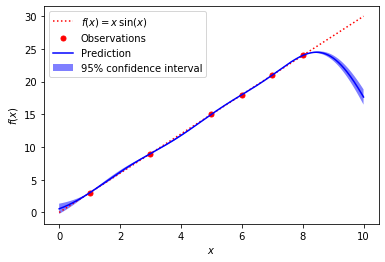

In [2]:
#GP from skikit learn

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
#RBF is squared exponential
from sklearn.gaussian_process.kernels import RBF


#Function to predict
def f(x):
    return 3*x

X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y = f(X).ravel()


x = np.atleast_2d(np.linspace(0, 10, 1000)).T

kernel = RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)

plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()



---
---
# An implementation of https://doi.org/10.1007/s10915-017-0625-2

### Interpolation:

0.03772964371217633

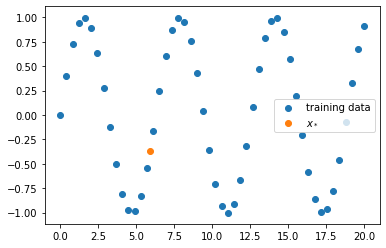

In [18]:
#Here's the data we'll try to interpolate with our homemade GP
N = 50
x = np.linspace(0,20,N)
y = np.sin(x)
plt.scatter(x,y, label='training data')

x_star = 5.9
plt.scatter(x_star, np.sin(x_star), label='$x_*$')
plt.legend();
np.mean(y)

$$K(\mathbf{x}, \mathbf{y})=K_{\mathrm{SE}}(\mathbf{x}, \mathbf{y})=\Sigma^{2} \exp \left[-\frac{(\mathbf{x}-\mathbf{y})^{2}}{2 \ell^{2}}\right]$$

In [41]:
def K_se(x,y, Σ=1, l=0.8):
    #
    #Hyperparameters:
    #Σ = 1 #for simplicity
    #l = 0.1 #shown to be optimal in FDGP paper
    
    return Σ**2 * np.exp(- (x-y)**2 / (2*l**2))

$$\bar{f}_{*}=\mathbf{k}_{*}^{T} \mathbf{K}^{-1} \mathbf{f}$$
where

$$\mathbf{f}=\left[f\left(\mathbf{x}_{1}\right), \ldots, f\left(\mathbf{x}_{N}\right)\right]^{T}$$
and
$$k_{*, i}=K\left(\mathbf{x}_{*}, x_{i}\right)$$

so I believe
$$\mathbf{k}_{*}^{T} = [K\left(\mathbf{x}_{*}, x_{1}\right), \ldots, K\left(\mathbf{x}_{*}, x_{N}\right)]$$

$$\mathbf{K} \rightarrow K_{i j} \equiv K\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)$$

In [42]:
def f_star(x,y, x_star):
    N = len(x)
    #construct K
    
    K = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            K[i,j] = K_se(x[i], x[j])

    #Construct K_* and f
    K_star = np.zeros(N)
    f = np.zeros(N)
    for i in range(N):
        K_star[i] = K_se(x_star, x[i])
        f[i] = y[i]
        
    
    step1 = np.matmul(K_star, np.linalg.inv(K))
    step2 = f.T - np.ones(N)*np.mean(y)
    
    f_star = np.mean(y) + np.matmul(step1, step2)
    
    #f_star = np.matmul(np.matmul(K_star, np.linalg.inv(K)), f.T)
        
    
    return f_star
#f_star(x,y,x_star)

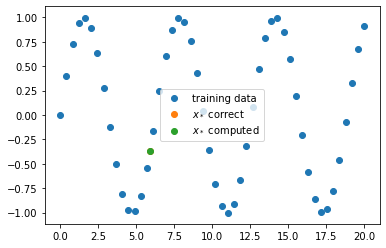

In [43]:
y_star = f_star(x,y, x_star) 

plt.scatter(x,y, label='training data')

plt.scatter(x_star, np.sin(x_star), label='$x_*$ correct')
plt.scatter(x_star, y_star, label='$x_*$ computed')


plt.legend();

# Lets try another example of interpolation with less data

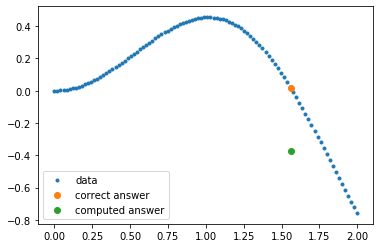

In [128]:
def f(x):
    return x*np.sin(x)*np.cos(x)

#training data
x = np.linspace(0,2,100)
y = f(x)

#correct answer
x_star = 1.56
y_star_correct = f(x_star)

#GP interpolation
y_star = f_star(x,y, x_star)

#plot results
plt.scatter(x,y,marker='.',label="data")
plt.scatter(x_star, y_star_correct, label='correct answer')
plt.scatter(x_star, y_star, label='computed answer')
plt.legend();

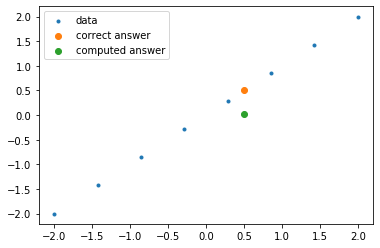

In [136]:
def f(x):
    return x

#training data
x = np.linspace(-2,2,8)
y = f(x)

#correct answer
x_star = 0.5
y_star_correct = f(x_star)

#GP interpolation
y_star = f_star(x,y, x_star)

#plot results
plt.scatter(x,y,marker='.',label="data")
plt.scatter(x_star, y_star_correct, label='correct answer')
plt.scatter(x_star, y_star, label='computed answer')
plt.legend();

### Reconstruction

Reconstruction is where we have volume averaged integral quantities: $$\left\langle q_{i}\right\rangle=\frac{1}{\Delta \mathcal{V}_{i}} \int_{\Delta \mathcal{V}_{i}} q\left(\mathbf{x}, t^{n}\right) d \mathcal{V}$$ like in a finite volume method. Our task is to find  the flux at the interface of the cells. This is a change of data type. Going from volume to pointwise value.

This is also seen in finite difference methods. We want to find edge values given integral quantities of cells. 

FVM  - Input: $\frac{1}{\Delta \mathcal{V}_{i}} \int_{\Delta \mathcal{V}_{i}} q\left(\mathbf{x}, t^{n}\right) d \mathcal{V}$ - Output: $q\left(\mathbf{x}, t^{n}\right)$

FDM - Input: $F\left(q_{i}\right)$ - Output: $\hat{F}_{i+\frac{1}{2}}$

(Both require change of data type. Volume quantity to a discrete data point. 

Here we will modify GP interpolation to handle this "change of data types."

---
Here GP reconstruction is defined. On a stensil that takes p points from behind and r points from the front.
$$G_{k} \equiv \int f(\mathbf{x}) d g_{k}(\mathbf{x}), k=i-p, \ldots, i+r$$
where $$d g_{k}(\mathbf{x}), k=i-p, \ldots, i+r$$

and 
$$d g_{k}(\mathbf{x})=\left\{\begin{array}{ll}d^{3} \mathbf{x} \times \prod_{d=x, y, z} \frac{1}{\Delta^{(d)}} & \text { if } \mathbf{x} \in I_{k} \\ 0 & \text { if } \mathbf{x} \notin I_{k}\end{array}\right.$$

$\Delta^{(d)}$ is just dx, but in the directions. Theoretically, dx could be different than dy

So, the pointwise function value $f\left(\mathbf{x}_{*}\right)$ reconstructed from volume average data $G$ is given by:

$$\tilde{f}_{*}=\bar{f}\left(\mathbf{x}_{*}\right)+\mathbf{T}_{*}^{T} \mathbf{C}^{-1}(\mathbf{G}-\overline{\mathbf{G}})$$

In [130]:
from scipy.special import erf
from numpy import sqrt, exp, pi

def getC(x_k,x_h, Δ):
    #eq 22
    l=0.1
    Δkh = (x_k - x_h)/Δ
    
    
    Ckh = sqrt(pi)* (l/Δ)**2 * (
    
    ( (Δkh + 1)/(sqrt(2)*l/Δ) * erf( (Δkh + 1)/(sqrt(2)*l/Δ) ) 
    + (Δkh - 1)/(sqrt(2)*l/Δ) * erf((Δkh - 1)/(sqrt(2)*l/Δ)) )
    
    + 1/sqrt(pi) * ( exp( - (Δkh + 1)**2 / (2 * (l/Δ)**2 ) ) 
    + exp( - (Δkh - 1)**2 / (2 * (l/Δ)**2 ) ) )
    
    -2 * ( Δkh/(sqrt(2)*l/Δ ) * erf( Δkh/(sqrt(2)*l/Δ) )
    + 1/sqrt(pi) * exp( -Δkh**2/(2*(l/Δ)**2) ) ) )
    
    return Ckh


def getT(x_χ, x_k, Δ):
    #eq 23
    #χ = * in paper
    l=0.1
    Δχk = (x_χ - x_k)/Δ
    
    T_χk = sqrt(pi/2) * (l/Δ) * (
    erf( (Δχk + 0.5) / (sqrt(2)*l/Δ) )
    - erf( (Δχk - 0.5) / (sqrt(2)*l/Δ) ) )
    
    return T_χk

1 D constant mean, $x_* = x_{i \pm \frac{1}{2}}$ eq. 20

$$\overline{\mathbf{G}}=f_{0} \mathbf{1}_{r+p+1} $$
$$\tilde{f}_{i \pm \frac{1}{2}}=f_{0}+\mathbf{T}_{i \pm \frac{1}{2}}^{T} \mathbf{C}^{-1}\left(\mathbf{G}-f_{0} \mathbf{1}_{r+p+1}\right)$$

In [131]:
#1D reconstruction....

def f_star_reconstruction_1d(x, y, i, p=2, r=2):
    #i index of x[i]. We compute x[i ± 0.5]
    #p is points below
    #r is points above
    #eq 20
    
    ################# x_i +1/2##############################
    N = p+r+1 
    dx = (x[-1] - x[0])/(len(x)-1)
    f0 = np.mean(y)
    
    T = np.zeros(N)
    for ii in range(i-p, i+r+1):
        T[ii - (i-p)] = getT(x[i]+0.5*dx, x[ii], dx)
    
    C = np.zeros([N,N])
    for ii in range(i-p, i+r+1):
        for jj in range(i-p, i+r+1):
            C[ii - (i-p), jj - (i-p)] = getT(x[ii], x[jj], dx)
            
    G = y[i-p-1:i+r]
    Gbar = f0*np.ones(N)

    
    z = np.matmul(T.T, np.linalg.inv(C))
    
    _G = G-Gbar  
    
    f_x_plus_half = f0 + np.dot(z, _G)
    
        
    ################# x_i - 1/2##############################
    N = p+r+1 
    dx = (x[-1] - x[0])/(len(x)-1)
    f0 = np.mean(y)
    
    T = np.zeros(N)
    for ii in range(i-p, i+r+1):
        T[ii - (i-p)] = getT(x[i]-0.5*dx, x[ii], dx)
    
    C = np.zeros([N,N])
    for ii in range(i-p, i+r+1):
        for jj in range(i-p, i+r+1):
            C[ii - (i-p), jj - (i-p)] = getT(x[ii], x[jj], dx)
            
    G = y[i-p-1:i+r]
    Gbar = f0*np.ones(N)

    
    z = np.matmul(T.T, np.linalg.inv(C))
    
    _G = G-Gbar  
    
    f_x_minus_half = f0 + np.dot(z, _G)
    
    return f_x_plus_half, f_x_minus_half

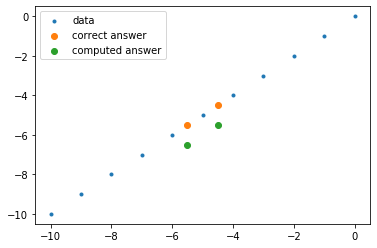

In [134]:
def f(x):
    return x

#training data
x = np.linspace(-10,0,11)
y = f(x)
dx = (x[-1] - x[0])/(len(x)-1)

x_i = 5
x_i_plus = x[x_i] + 0.5*dx
x_i_minus = x[x_i] - 0.5*dx

#solution 
y_i_plus  = f(x_i_plus)
y_i_minus = f(x_i_minus)

#gaussian process reconstruction
numy_i_plus, numy_i_minus = f_star_reconstruction_1d(x,y, x_i)


#plot results
plt.scatter(x,y,marker='.',label="data")
plt.scatter([x_i_plus, x_i_minus], [y_i_plus, y_i_minus], label='correct answer')
plt.scatter([x_i_plus, x_i_minus], [numy_i_plus, numy_i_minus], label='computed answer')
plt.legend();